In [2]:
import xarray as xr
import numpy as np
import netCDF4 as nc
import matplotlib.pyplot as plt
import pandas as pd

In [3]:
import os
import sys
import xarray as xr
import netCDF4 as nc

print("=== ДИАГНОСТИКА ===")
print("1. Текущая папка:", os.getcwd())
print("2. Файл существует:", os.path.exists('US-Baltimore_clean_observations_v1.nc'))
print("3. Python exe:", sys.executable)

# Проверяем оба способа
print("\n4. Проверка netCDF4:")
try:
    ds_nc = nc.Dataset('US-Baltimore_clean_observations_v1.nc', 'r')
    print("   ✅ netCDF4 видит файл")
    ds_nc.close()
except Exception as e:
    print("   ❌ netCDF4:", e)

print("\n5. Проверка xarray:")
try:
    ds_xr = xr.open_dataset(r"C:\US-Baltimore_clean_observations_v1.nc", engine='netcdf4')
    print("   ✅ xarray видит файл")
except Exception as e:
    print("   ❌ xarray:", e)

=== ДИАГНОСТИКА ===
1. Текущая папка: c:\Users\User\OneDrive\Документы\GitHub\turbulent-fluxes-urban-ml
2. Файл существует: True
3. Python exe: c:\Users\User\anaconda3\envs\python312\python.exe

4. Проверка netCDF4:
   ✅ netCDF4 видит файл

5. Проверка xarray:
   ✅ xarray видит файл


In [7]:
dataset = nc.Dataset('US-Baltimore_clean_observations_v1.nc', 'r')
print (dataset.dimensions)
print (list(dataset.variables.keys()))

{'time': "<class 'netCDF4.Dimension'>": name = 'time', size = 43824}
['time', 'SWdown', 'LWdown', 'Tair', 'Qair', 'PSurf', 'Rainf', 'Snowf', 'Wind_N', 'Wind_E', 'SWup', 'LWup', 'Qle', 'Qh', 'SoilTemp', 'Qtau', 'SWdown_qc', 'LWdown_qc', 'Tair_qc', 'Qair_qc', 'PSurf_qc', 'Rainf_qc', 'Snowf_qc', 'Wind_N_qc', 'Wind_E_qc', 'SWup_qc', 'LWup_qc', 'Qle_qc', 'Qh_qc', 'SoilTemp_qc', 'Qtau_qc']


In [4]:
dataset = xr.open_dataset(r"C:\US-Baltimore_clean_observations_v1.nc", engine='netcdf4') #только для чтения
print(dataset)

<xarray.Dataset> Size: 4MB
Dimensions:      (time: 43824)
Coordinates:
  * time         (time) datetime64[ns] 351kB 2002-01-01T05:00:00 ... 2007-01-...
Data variables: (12/30)
    SWdown       (time) float32 175kB ...
    LWdown       (time) float32 175kB ...
    Tair         (time) float32 175kB ...
    Qair         (time) float32 175kB ...
    PSurf        (time) float32 175kB ...
    Rainf        (time) float32 175kB ...
    ...           ...
    SWup_qc      (time) int8 44kB ...
    LWup_qc      (time) int8 44kB ...
    Qle_qc       (time) int8 44kB ...
    Qh_qc        (time) int8 44kB ...
    SoilTemp_qc  (time) int8 44kB ...
    Qtau_qc      (time) int8 44kB ...
Attributes: (12/24)
    title:                      Flux tower observations from US-Baltimore (af...
    summary:                    Quality controlled flux tower observations fo...
    sitename:                   US-Baltimore
    long_sitename:              Cub Hill, Baltimore, United States
    version:                

In [5]:
for var_name in ['Qh', 'Qle', 'Qtau', 'Tair', 'Wind_N', 'Wind_E']: #используемые предикторы
    if var_name in dataset.data_vars:
        data = dataset[var_name]
        missing_count = np.isnan(data).sum().item()
        missing_pct = (missing_count / data.size)*100
        print (f"{var_name}: {missing_count}/{data.size} пропусков({missing_pct:.2f}%)")

Qh: 14336/43824 пропусков(32.71%)
Qle: 24166/43824 пропусков(55.14%)
Qtau: 7615/43824 пропусков(17.38%)
Tair: 248/43824 пропусков(0.57%)
Wind_N: 7472/43824 пропусков(17.05%)
Wind_E: 7472/43824 пропусков(17.05%)


In [6]:
for var_name in ['Qh', 'Qle', 'Qtau', 'Tair', 'Wind_N', 'Wind_E']:
    data = dataset[var_name]
    missing_count = np.isnan(data).sum().item()
    data_interpolated = data.interpolate_na(dim='time', method='linear') #линейная интерполяция
    missing_after_linear = np.isnan(data_interpolated).sum().item()
    filled_count = missing_count - missing_after_linear
    print(f"{var_name}:")
    print(f"  Линейная интерполяция: заполнено {filled_count}")
    print(f"  Осталось после линейной: {missing_after_linear}")

    missing_after_seasonal = missing_after_linear

    if missing_after_linear > 0:
        data_interpolated = data_interpolated.ffill(dim='time', limit=24) #интерполяция вперед на сутки
        data_interpolated = data_interpolated.bfill(dim='time', limit=24) #назад
        missing_after_seasonal = np.isnan(data_interpolated).sum().item()
        filled_seasonal = missing_after_linear - missing_after_seasonal
        print(f"  Сезонное заполнение: заполнено {filled_seasonal}")
        print(f"  Осталось после сезонного: {missing_after_seasonal}")

    if missing_after_seasonal > 0:
        data_interpolated = data_interpolated.ffill(dim='time') #агрессивная интерполяция
        data_interpolated = data_interpolated.bfill(dim='time')
        missing_after_aggressive = np.isnan(data_interpolated).sum().item()
        filled_aggressive = missing_after_seasonal - missing_after_aggressive
        print(f"  Агрессивное заполнение: заполнено {filled_aggressive}")
        print(f"  Осталось после агрессивного: {missing_after_aggressive}")
    
    dataset[var_name] = data_interpolated
    
    final_missing = np.isnan(dataset[var_name]).sum().item() #файнал результат
    total_filled = missing_count - final_missing
    print(f"итог: заполнено {total_filled} из {missing_count} пропусков")
    
    if final_missing == 0:
        print("пропуски устранены")
    else:
        print(f"осталось пропусков: {final_missing}")

Qh:
  Линейная интерполяция: заполнено 14331
  Осталось после линейной: 5
  Сезонное заполнение: заполнено 5
  Осталось после сезонного: 0
итог: заполнено 14336 из 14336 пропусков
пропуски устранены
Qle:
  Линейная интерполяция: заполнено 23915
  Осталось после линейной: 251
  Сезонное заполнение: заполнено 29
  Осталось после сезонного: 222
  Агрессивное заполнение: заполнено 222
  Осталось после агрессивного: 0
итог: заполнено 24166 из 24166 пропусков
пропуски устранены
Qtau:
  Линейная интерполяция: заполнено 7610
  Осталось после линейной: 5
  Сезонное заполнение: заполнено 5
  Осталось после сезонного: 0
итог: заполнено 7615 из 7615 пропусков
пропуски устранены
Tair:
  Линейная интерполяция: заполнено 248
  Осталось после линейной: 0
итог: заполнено 248 из 248 пропусков
пропуски устранены
Wind_N:
  Линейная интерполяция: заполнено 7467
  Осталось после линейной: 5
  Сезонное заполнение: заполнено 5
  Осталось после сезонного: 0
итог: заполнено 7472 из 7472 пропусков
пропуски устра

In [7]:
#сравнение датасетов
clean_obs = xr.open_dataset(r'C:\US-Baltimore_clean_observations_v1.nc', engine='netcdf4')
metforcing = xr.open_dataset(r'C:\US-Baltimore_metforcing_v1.nc', engine='netcdf4') 
our_cleaned = dataset.copy(deep=True)

In [10]:
# Открываем файл metforcing
metforcing = xr.open_dataset(r'C:\US-Baltimore_clean_observations_v1.nc', engine='netcdf4')
print("ДИАГНОСТИКА METFORCING:")
print("=" * 50)

# 1. Проверка ВСЕГО датасета
print("ВЕСЬ ДАТАСЕТ (43824 точек):")
for var in ['Qh', 'Qle', 'Qtau']:
    if var in metforcing.data_vars:
        all_data = metforcing[var]
        all_missing = np.isnan(all_data).sum().item()
        all_total = all_data.size
        print(f"{var}: {all_missing}/{all_total} пропусков ({all_missing/all_total*100:.1f}%)")


ДИАГНОСТИКА METFORCING:
ВЕСЬ ДАТАСЕТ (43824 точек):
Qh: 14336/43824 пропусков (32.7%)
Qle: 24166/43824 пропусков (55.1%)
Qtau: 7615/43824 пропусков (17.4%)


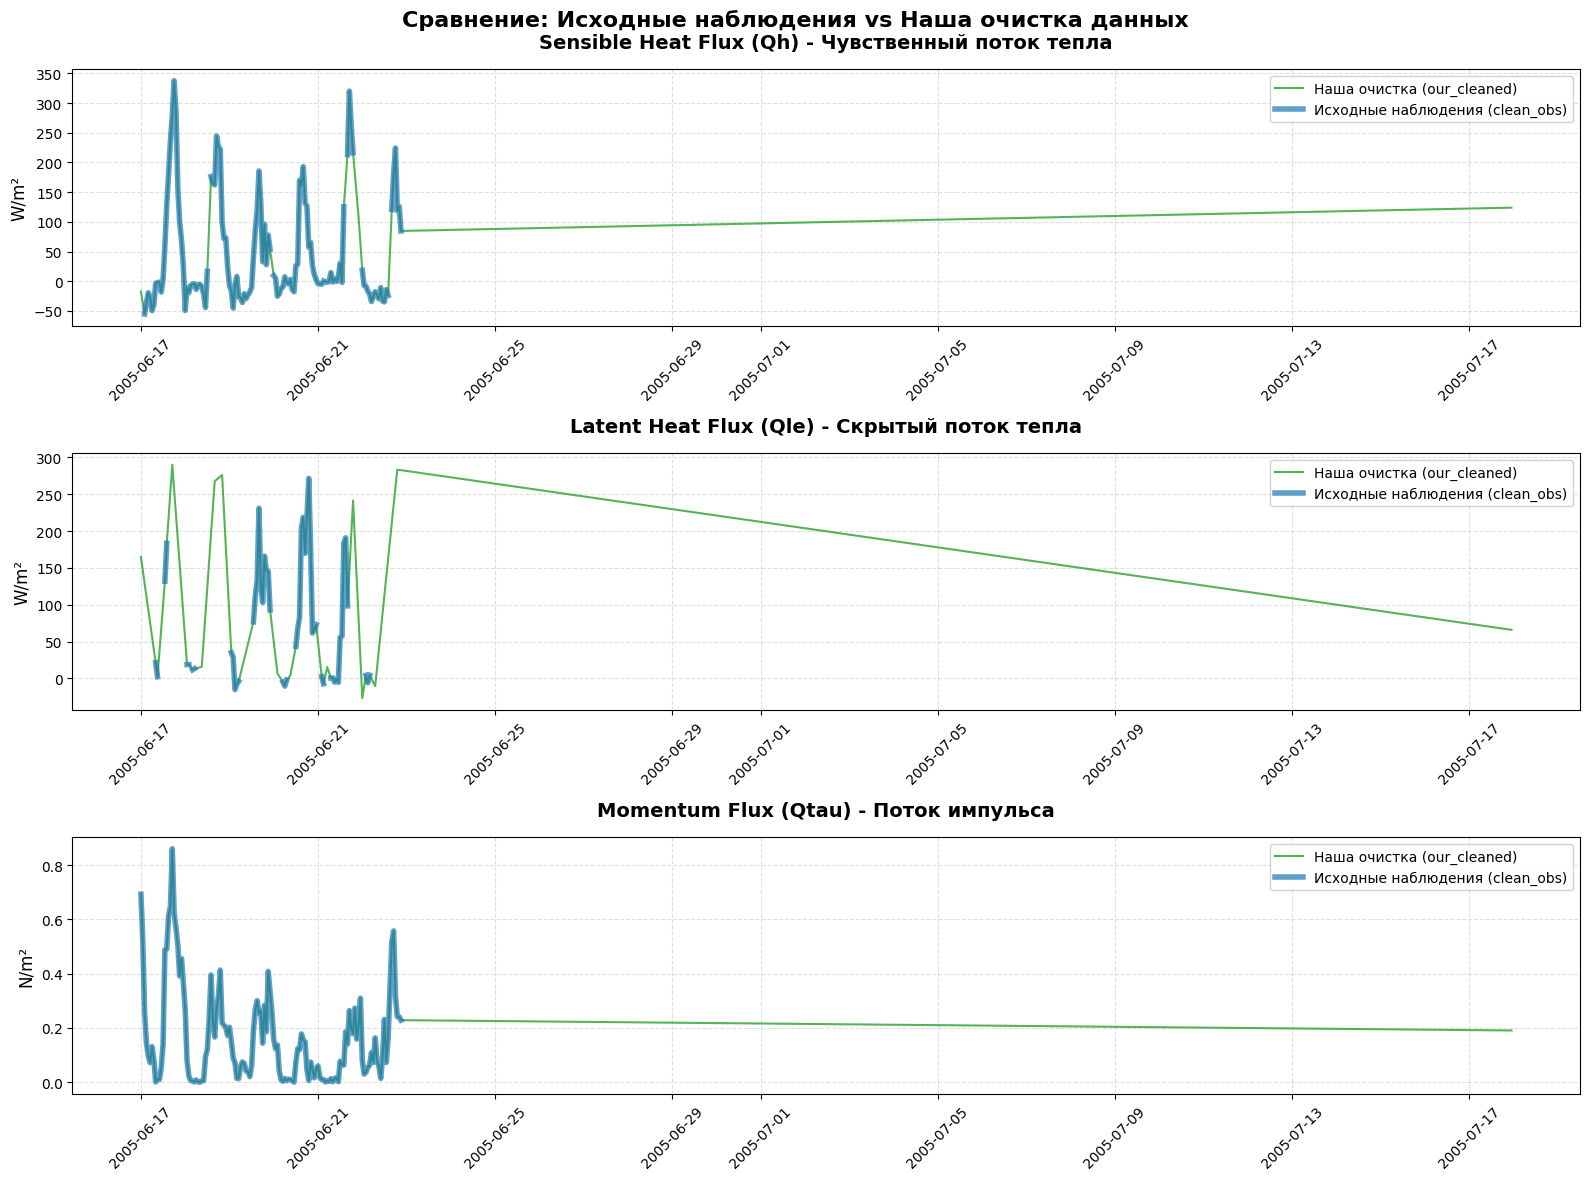

In [6]:


# Сравнение двух датасетов - наши очищенные данные vs исходные наблюдения
start_date = '2005-06-17'
end_date = '2005-07-17'

fig, axes = plt.subplots(3, 1, figsize=(16, 12))
fig.suptitle('Сравнение: Исходные наблюдения vs Наша очистка данных', fontsize=16, weight='bold')

variables = ['Qh', 'Qle', 'Qtau']
colors = ['#1f77b4', '#2ca02c']  # Синий и зеленый
labels = ['Исходные наблюдения (clean_obs)', 'Наша очистка (our_cleaned)']

for i, var in enumerate(variables):
    ax = axes[i]
    
    # 1. Наши очищенные данные - тонкая зеленая линия (ПЕРВЫМИ чтобы не перекрывать)
    if var in our_cleaned.data_vars:
        our_ts = our_cleaned[var].sel(time=slice(start_date, end_date))
        ax.plot(our_ts.time, our_ts, color=colors[1], linewidth=1.5, label=labels[1], alpha=0.8)
    
    # 2. Исходные данные - ОЧЕНЬ ЖИРНАЯ синяя линия
    if var in clean_obs.data_vars:
        obs_ts = clean_obs[var].sel(time=slice(start_date, end_date))
        ax.plot(obs_ts.time, obs_ts, color=colors[0], linewidth=4.0, label=labels[0], alpha=0.7)
    
    # Заголовки для каждого графика
    titles = {
        'Qh': 'Sensible Heat Flux (Qh) - Чувственный поток тепла',
        'Qle': 'Latent Heat Flux (Qle) - Скрытый поток тепла', 
        'Qtau': 'Momentum Flux (Qtau) - Поток импульса'
    }
    ax.set_title(titles[var], fontsize=14, pad=15, weight='bold')
    ax.set_ylabel('W/m²' if var != 'Qtau' else 'N/m²', fontsize=12)
    ax.grid(True, alpha=0.4, linestyle='--')
    ax.legend(fontsize=10, framealpha=0.9)
    ax.tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.subplots_adjust(top=0.93)
plt.show()


In [7]:
#статистика
for var in ['Qh', 'Qle', 'Qtau', 'Tair', 'Wind_N', 'Wind_E']:
    data = our_cleaned[var]
    print(f"{var}:")
    print(f" среднее: {data.mean().item():.2f}")
    print(f" медиана: {np.nanmedian(data.values):.2f}")
    print(f" станд отклонение: {data.std().item():.2f}")
    print(f" мин: {data.min().item():.2f}")
    print(f" макс: {data.max().item():.2f}")

Qh:
 среднее: 41.31
 медиана: 4.49
 станд отклонение: 86.99
 мин: -110.82
 макс: 472.66
Qle:
 среднее: 46.16
 медиана: 21.13
 станд отклонение: 69.55
 мин: -158.73
 макс: 390.64
Qtau:
 среднее: 0.26
 медиана: 0.16
 станд отклонение: 0.30
 мин: 0.00
 макс: 3.28
Tair:
 среднее: 285.97
 медиана: 286.39
 станд отклонение: 9.91
 мин: 256.41
 макс: 307.86
Wind_N:
 среднее: -0.61
 медиана: -0.80
 станд отклонение: 3.06
 мин: -12.39
 макс: 11.10
Wind_E:
 среднее: 0.93
 медиана: 0.86
 станд отклонение: 2.72
 мин: -12.85
 макс: 13.10


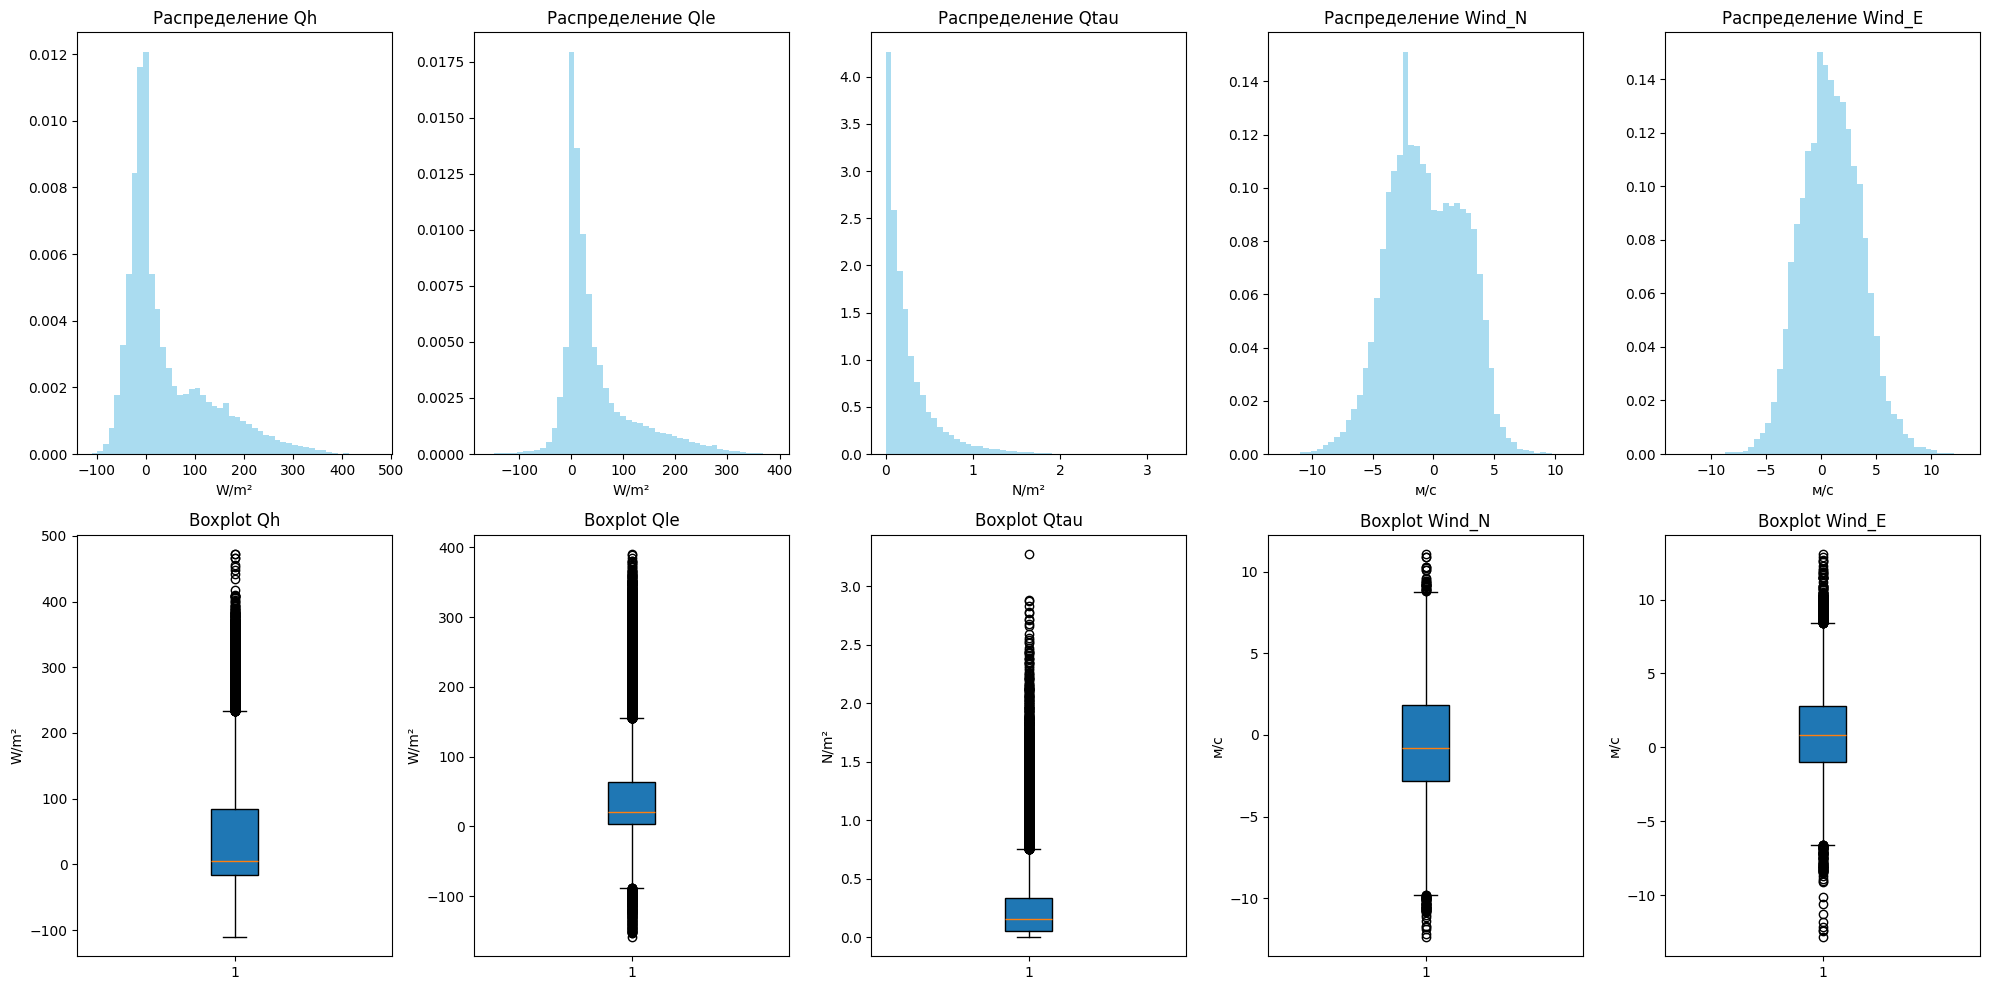

In [ ]:
import seaborn as sns

fig, axes = plt.subplots(2, 5, figsize=(20, 10))

# гистограммы распределений
variables = ['Qh', 'Qle', 'Qtau', 'Wind_N', 'Wind_E']

for i, var in enumerate(variables):

    axes[0, i].hist(our_cleaned[var].values, bins=50, alpha=0.7, density=True, color='skyblue')
    axes[0, i].set_title(f'Распределение {var}')
    

    if var in ['Qh', 'Qle']:
        axes[0, i].set_xlabel('W/m²')
    elif var == 'Qtau':
        axes[0, i].set_xlabel('N/m²')
    else:  
        axes[0, i].set_xlabel('м/с')
    
    # Boxplot
    axes[1, i].boxplot(our_cleaned[var].values, patch_artist=True)
    axes[1, i].set_title(f'Boxplot {var}')
    

    if var in ['Qh', 'Qle']:
        axes[1, i].set_ylabel('W/m²')
    elif var == 'Qtau':
        axes[1, i].set_ylabel('N/m²')
    else:  
        axes[1, i].set_ylabel('м/с')

plt.tight_layout()
plt.show()

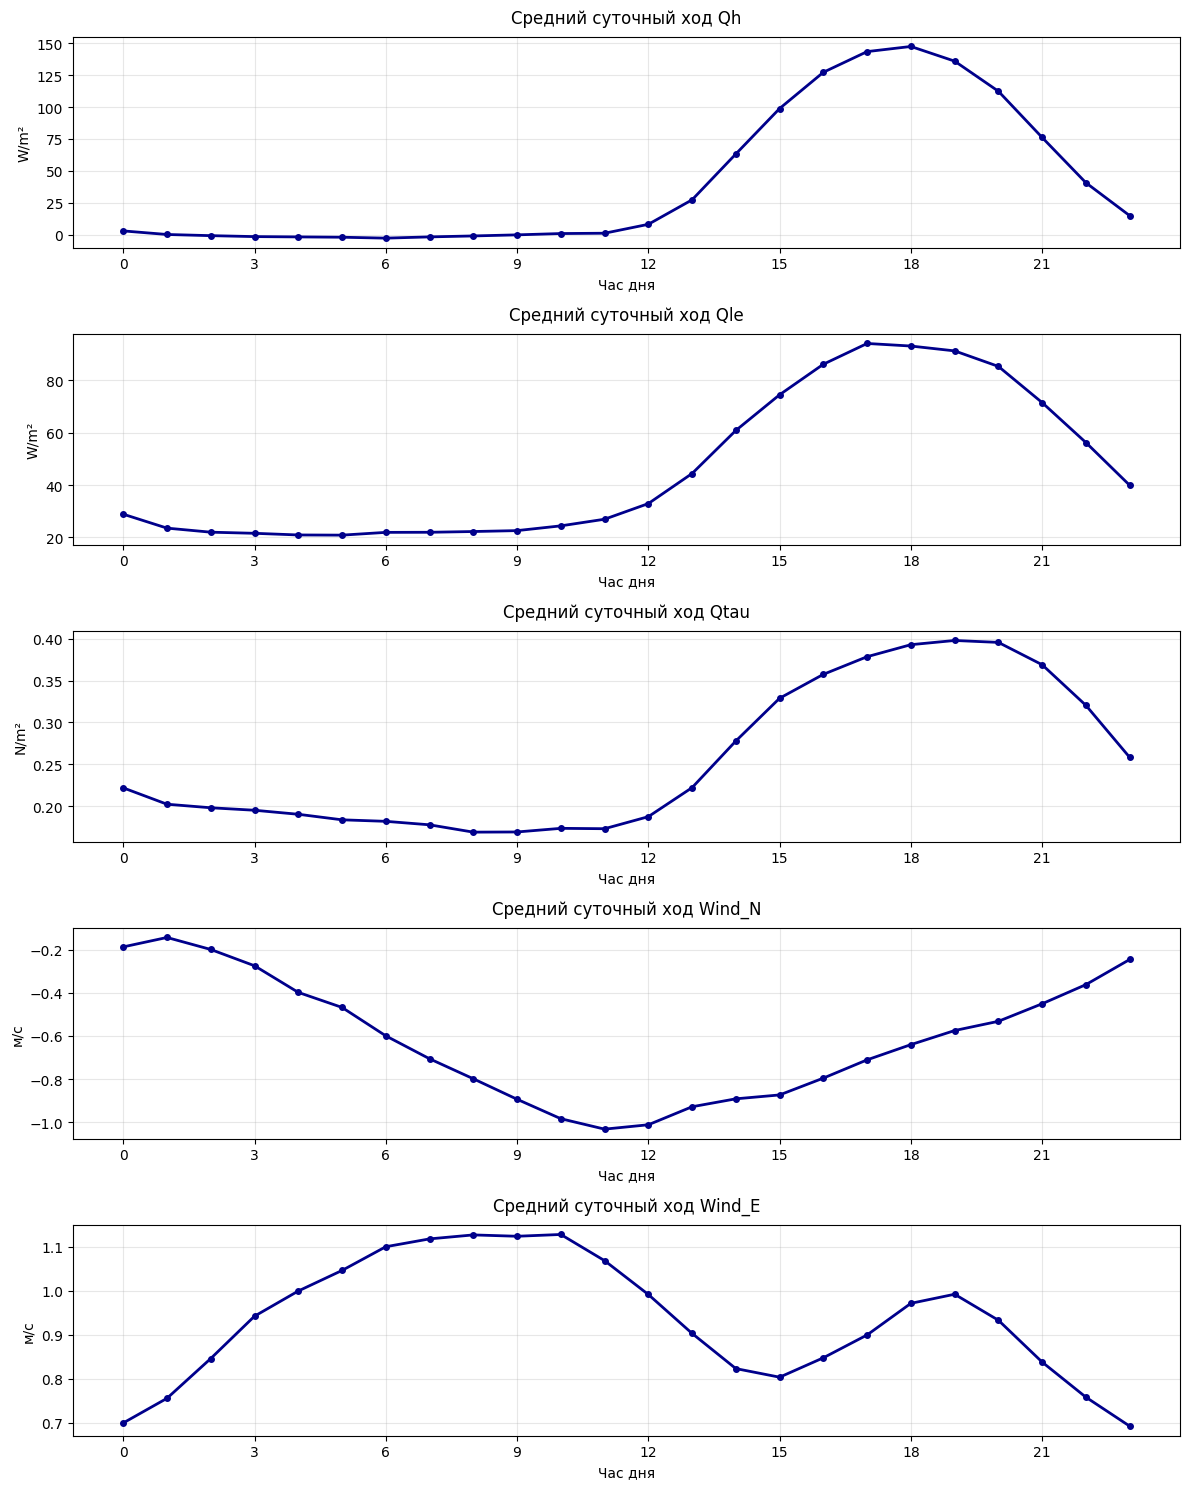

In [ ]:
# средний суточный ход 
fig, axes = plt.subplots(5, 1, figsize=(12, 15))

variables = ['Qh', 'Qle', 'Qtau', 'Wind_N', 'Wind_E']

for i, var in enumerate(variables):
    # Группируем по часам
    hourly_means = our_cleaned[var].groupby('time.hour').mean()
    
    axes[i].plot(hourly_means.hour, hourly_means, 'o-', linewidth=2, markersize=4, color='darkblue')
    axes[i].set_title(f'Средний суточный ход {var}', fontsize=12, pad=10)
    axes[i].set_xlabel('Час дня')
    
    # Подписи осей в зависимости от переменной
    if var in ['Qh', 'Qle']:
        axes[i].set_ylabel('W/m²')
    elif var == 'Qtau':
        axes[i].set_ylabel('N/m²')
    else:  
        axes[i].set_ylabel('м/с')
    
    axes[i].grid(True, alpha=0.3)
    axes[i].set_xticks(range(0, 24, 3))

plt.tight_layout()
plt.show()

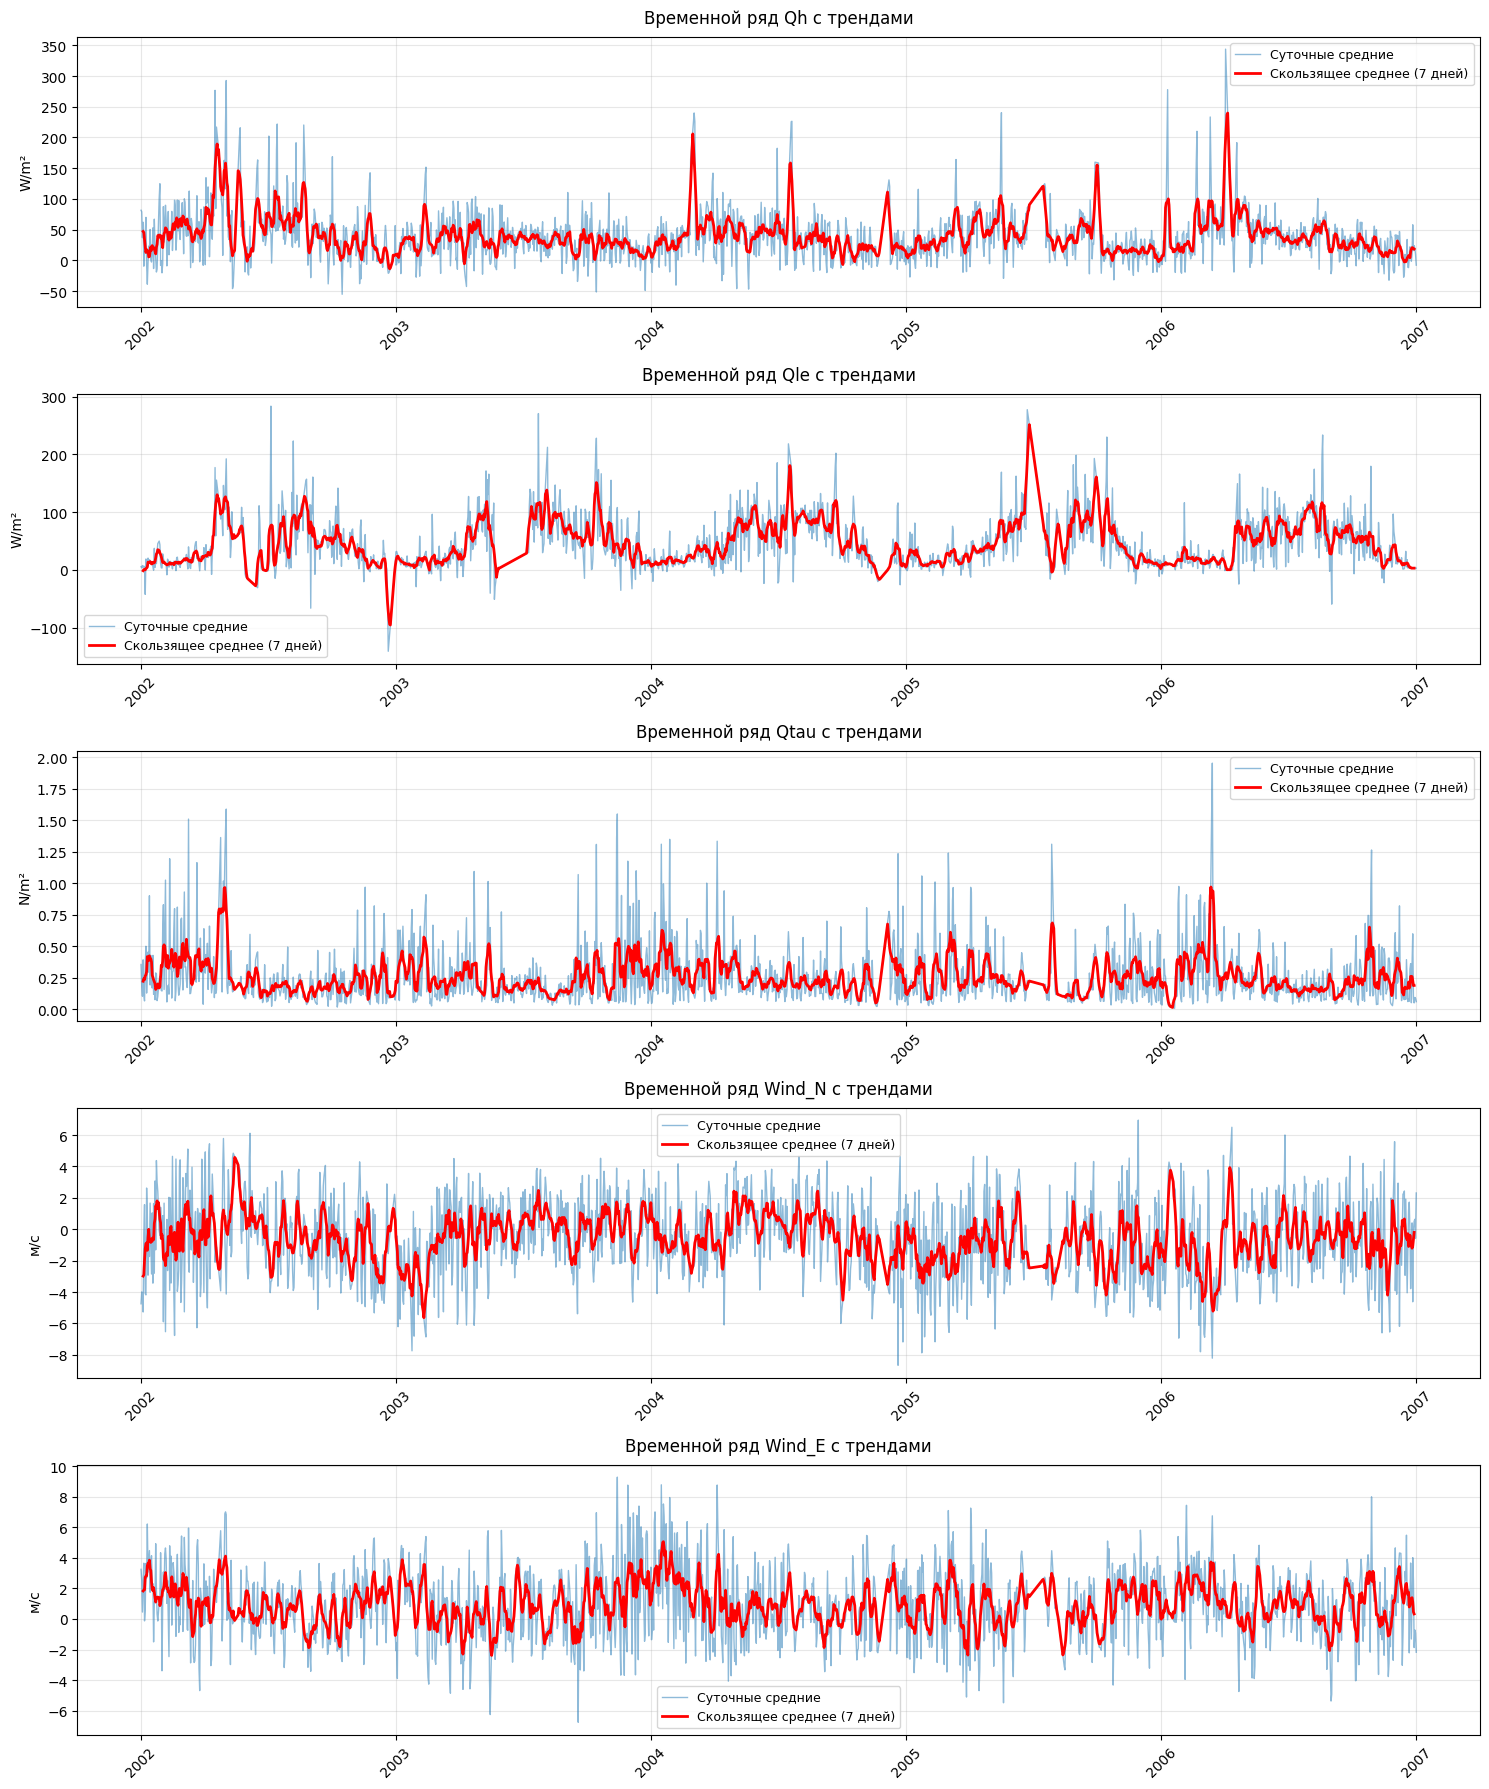

In [ ]:
# анализ временных рядов (тренды, сезонность)
fig, axes = plt.subplots(5, 1, figsize=(15, 18))

for i, var in enumerate(variables):
    data = our_cleaned[var]
    
    # Скользящее среднее за 7 дней
    daily_means = data.resample(time='1D').mean()
    weekly_avg = daily_means.rolling(time=7, center=True).mean()
    
    axes[i].plot(daily_means.time, daily_means, alpha=0.5, label='Суточные средние', linewidth=1)
    axes[i].plot(weekly_avg.time, weekly_avg, linewidth=2, label='Скользящее среднее (7 дней)', color='red')
    axes[i].set_title(f'Временной ряд {var} с трендами', fontsize=12, pad=10)
    
    # Подписи осей в зависимости от переменной
    if var in ['Qh', 'Qle']:
        axes[i].set_ylabel('W/m²')
    elif var == 'Qtau':
        axes[i].set_ylabel('N/m²')
    else:  
        axes[i].set_ylabel('м/с')
        
    axes[i].legend(fontsize=9)
    axes[i].grid(True, alpha=0.3)
    axes[i].tick_params(axis='x', rotation=45)

plt.tight_layout()
plt.show()

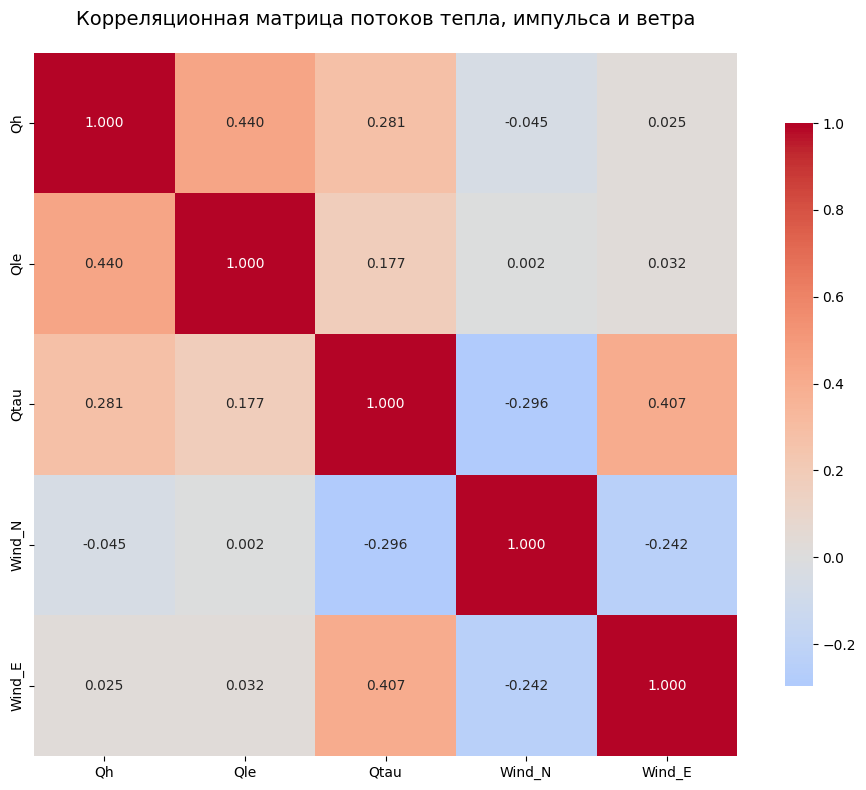

In [ ]:
# корреляционный анализ
# Создаем DataFrame для корреляционного анализа
flux_data = pd.DataFrame({
    'Qh': our_cleaned['Qh'].values,
    'Qle': our_cleaned['Qle'].values, 
    'Qtau': our_cleaned['Qtau'].values,
    'Wind_N': our_cleaned['Wind_N'].values,
    'Wind_E': our_cleaned['Wind_E'].values
})

# Матрица корреляций
corr_matrix = flux_data.corr()

plt.figure(figsize=(10, 8))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', center=0,
            square=True, fmt='.3f', cbar_kws={'shrink': 0.8})
plt.title('Корреляционная матрица потоков тепла, импульса и ветра', fontsize=14, pad=20)
plt.tight_layout()
plt.show()

АНАЛИЗ ДИСПЕРСИЙ И ИЗМЕНЧИВОСТИ:

Qh:
   Дисперсия: 7567.28
   Стандартное отклонение: 86.99
   Среднее: 41.31
   Коэффициент вариации: 2.11
   Изменчивость: высокая

Qle:
   Дисперсия: 4837.81
   Стандартное отклонение: 69.55
   Среднее: 46.16
   Коэффициент вариации: 1.51
   Изменчивость: высокая

Qtau:
   Дисперсия: 0.09
   Стандартное отклонение: 0.30
   Среднее: 0.26
   Коэффициент вариации: 1.19
   Изменчивость: высокая

Wind_N:
   Дисперсия: 9.38
   Стандартное отклонение: 3.06
   Среднее: -0.61
   Коэффициент вариации: 5.00
   Изменчивость: высокая

Wind_E:
   Дисперсия: 7.41
   Стандартное отклонение: 2.72
   Среднее: 0.93
   Коэффициент вариации: 2.92
   Изменчивость: высокая


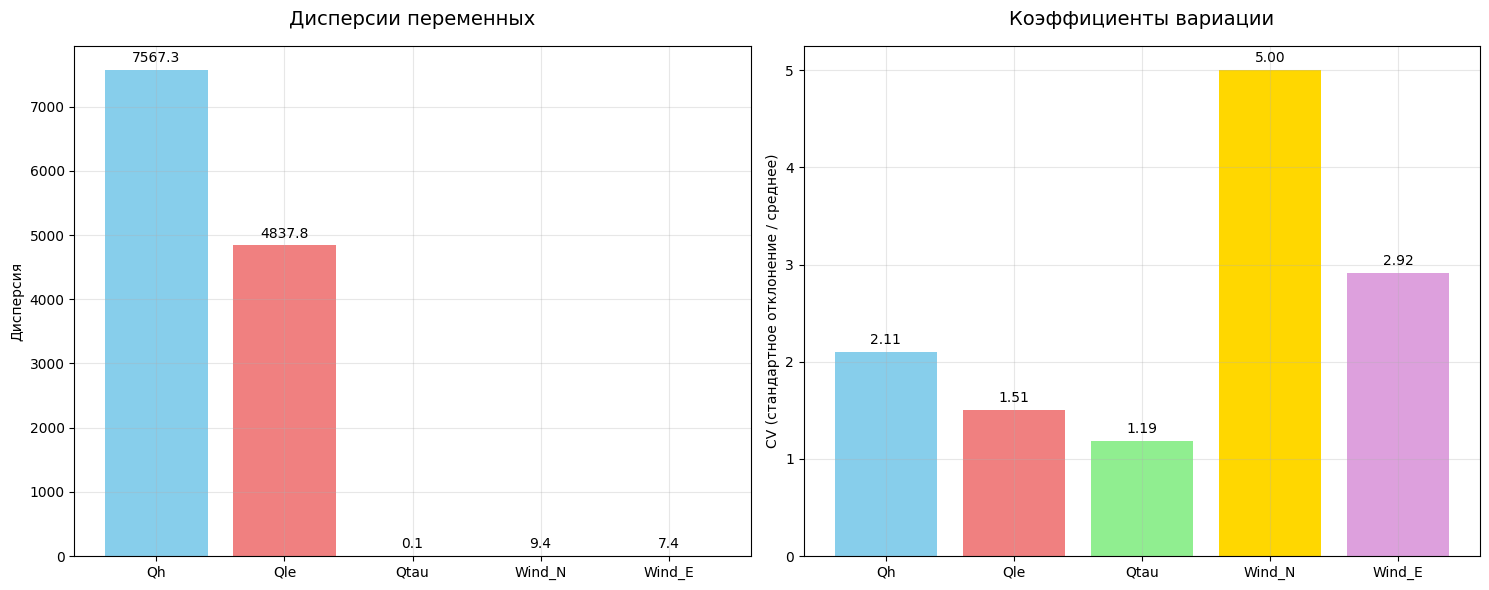


 СЕЗОННАЯ ИЗМЕНЧИВОСТЬ (дисперсия по месяцам):
Qh: макс.дисперсия - месяц 4, мин.дисперсия - месяц 12
Qle: макс.дисперсия - месяц 7, мин.дисперсия - месяц 1
Qtau: макс.дисперсия - месяц 3, мин.дисперсия - месяц 8
Wind_N: макс.дисперсия - месяц 3, мин.дисперсия - месяц 7
Wind_E: макс.дисперсия - месяц 4, мин.дисперсия - месяц 8


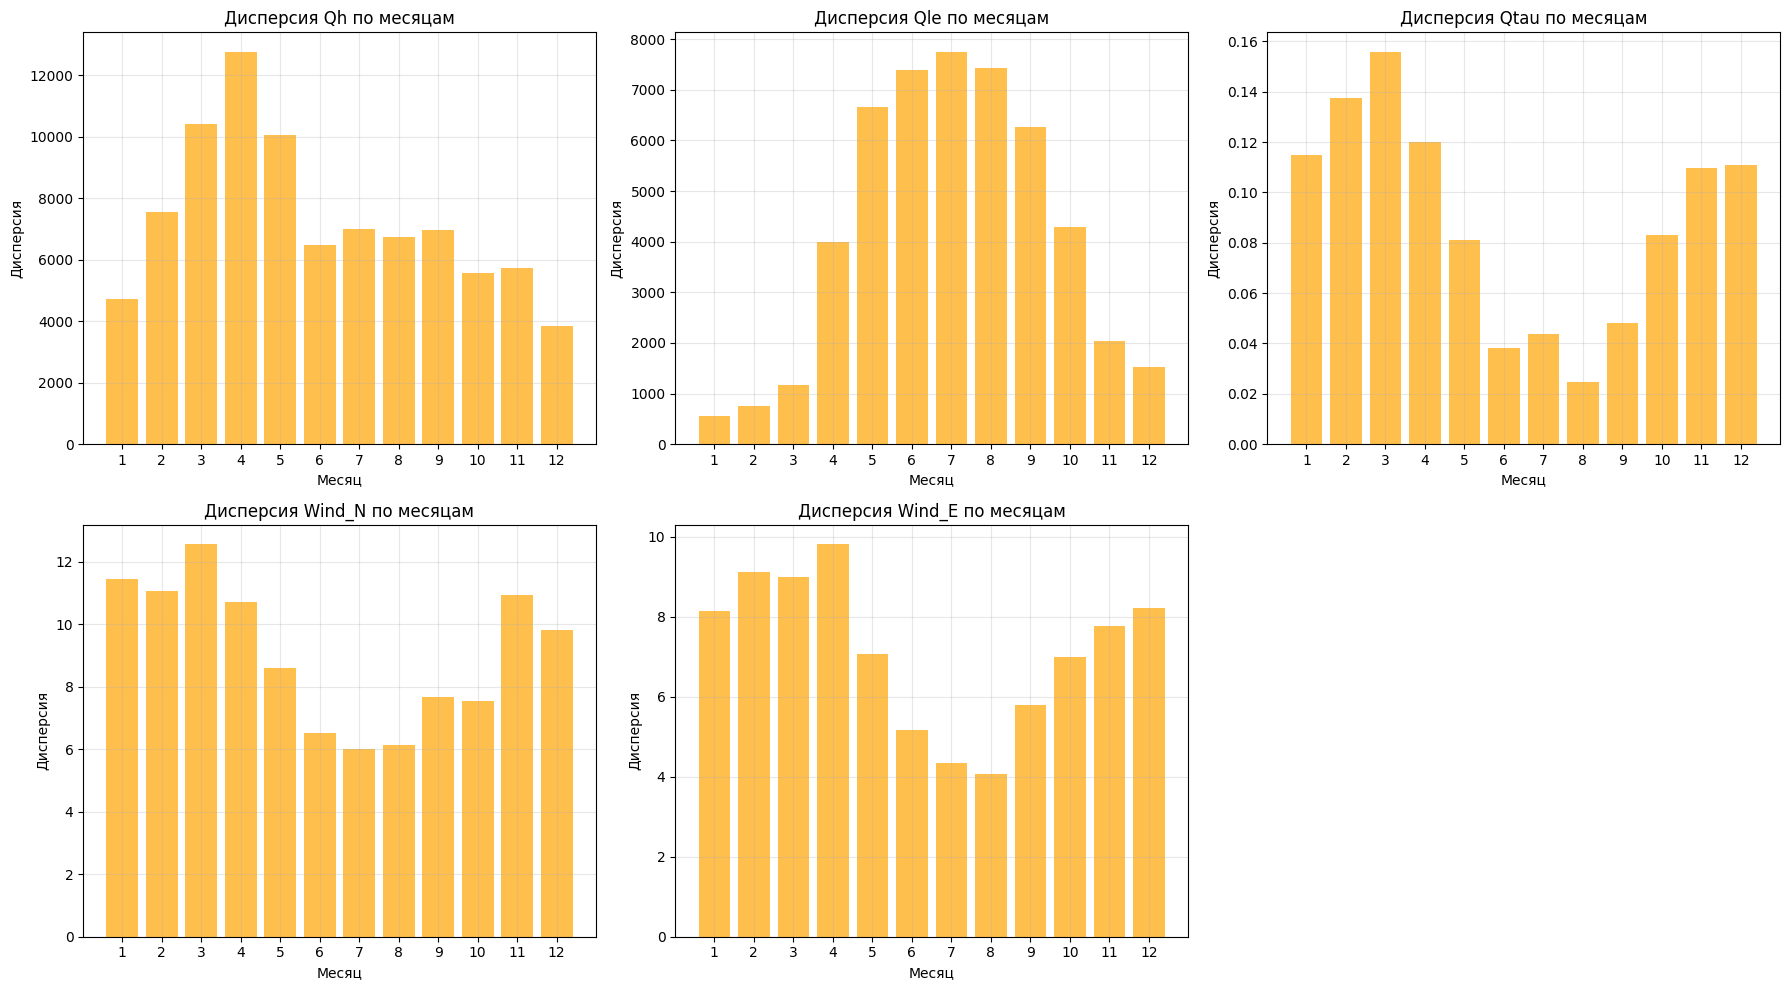

In [11]:
# анализ дисперсий и изменчивости
print("АНАЛИЗ ДИСПЕРСИЙ И ИЗМЕНЧИВОСТИ:")
print("=" * 50)

variables = ['Qh', 'Qle', 'Qtau', 'Wind_N', 'Wind_E']

for var in variables:
    data = our_cleaned[var].values
    variance = np.var(data)
    std = np.std(data)
    mean = np.mean(data)
    cv = std / abs(mean) if mean != 0 else np.inf  # Коэффициент вариации
    
    print(f"\n{var}:")
    print(f"   Дисперсия: {variance:.2f}")
    print(f"   Стандартное отклонение: {std:.2f}")
    print(f"   Среднее: {mean:.2f}")
    print(f"   Коэффициент вариации: {cv:.2f}")
    
    # Интерпретация коэффициента вариации
    if cv < 0.1:
        variability = "низкая"
    elif cv < 0.3:
        variability = "умеренная" 
    else:
        variability = "высокая"
    print(f"   Изменчивость: {variability}")

# Визуализация дисперсий
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(15, 6))

# График дисперсий
variances = [np.var(our_cleaned[var].values) for var in variables]
bars = ax1.bar(variables, variances, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'])
ax1.set_title('Дисперсии переменных', fontsize=14, pad=15)
ax1.set_ylabel('Дисперсия')
ax1.grid(True, alpha=0.3)

# Добавляем подписи значений на столбцы
for bar, variance in zip(bars, variances):
    height = bar.get_height()
    ax1.text(bar.get_x() + bar.get_width()/2., height + max(variances)*0.01,
             f'{variance:.1f}', ha='center', va='bottom')

# График коэффициентов вариации
cvs = [np.std(our_cleaned[var].values) / abs(np.mean(our_cleaned[var].values)) for var in variables]
bars2 = ax2.bar(variables, cvs, color=['skyblue', 'lightcoral', 'lightgreen', 'gold', 'plum'])
ax2.set_title('Коэффициенты вариации', fontsize=14, pad=15)
ax2.set_ylabel('CV (стандартное отклонение / среднее)')
ax2.grid(True, alpha=0.3)

# Добавляем подписи значений на столбцы
for bar, cv in zip(bars2, cvs):
    height = bar.get_height()
    ax2.text(bar.get_x() + bar.get_width()/2., height + max(cvs)*0.01,
             f'{cv:.2f}', ha='center', va='bottom')

plt.tight_layout()
plt.show()

# Сезонная изменчивость - дисперсия по месяцам
print(f"\n СЕЗОННАЯ ИЗМЕНЧИВОСТЬ (дисперсия по месяцам):")
print("=" * 55)

fig, axes = plt.subplots(2, 3, figsize=(18, 10))
axes = axes.flatten()

for i, var in enumerate(variables):
    # Дисперсия по месяцам
    monthly_variance = our_cleaned[var].groupby('time.month').var()
    
    axes[i].bar(monthly_variance.month, monthly_variance, alpha=0.7, color='orange')
    axes[i].set_title(f'Дисперсия {var} по месяцам', fontsize=12)
    axes[i].set_xlabel('Месяц')
    axes[i].set_ylabel('Дисперсия')
    axes[i].set_xticks(range(1, 13))
    axes[i].grid(True, alpha=0.3)
    
    # Выводим статистику
    max_var_month = monthly_variance.argmax().item() + 1
    min_var_month = monthly_variance.argmin().item() + 1
    print(f"{var}: макс.дисперсия - месяц {max_var_month}, мин.дисперсия - месяц {min_var_month}")

# Скрываем лишний subplot
axes[5].set_visible(False)

plt.tight_layout()
plt.show()